In [14]:
%matplotlib inline

In [6]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [8]:
def plot_grid(plots, figsize, col8row, margin=0.05):

    col_n, row_n = col8row
    plot_n = len(plots)
    w = (1 - margin) / col_n
    h = (1 - margin) / row_n
    l = b = margin

    plt.figure(figsize=figsize)
    
    graphs = [plt.axes([l+w*(i%col_n), 
              b+h*(i//col_n), 
              w, h])
              for i in range(plot_n)]

    for i in range(plot_n):
        graph, plot = graphs[i], plots[i]
        cond = len(plot.shape) > 2
        plot = plot.swapaxes(0, 1) if cond else plot
        x_pts = plot[..., 0]
        y_pts = plot[..., 1]
        graph.plot(x_pts, y_pts)
        graph.get_xaxis().set_visible(False)
        graph.get_yaxis().set_visible(False)
        graph.axis([-2, 2, -2, 2])
        
    plt.show()
  
    
def rotate(A, ro):
    sin, cos = np.sin, np.cos
    angle = np.pi/180*ro
    ro_mat = np.array(
        [cos(angle), -sin(angle), sin(angle), cos(angle)]
    ).reshape(2, 2)
    return A.dot(ro_mat)


def get_polygon(n):
    min_angle = np.pi*2/n
    sin, cos = np.sin, np.cos
    get_pts = (lambda i: [cos(min_angle*i), sin(min_angle*i)])
    polygon = np.array([get_pts(i) for i in range(n+1)])
    revision_angle = 180*(n-2)/(n*2)
    return rotate(polygon, revision_angle)


def get_random_polygons_plot(seed):

    def get_polygon_(mo_vac):
        n_angle = np.random.randint(3, 7)
        A = get_polygon(n_angle)
        return A/4+np.array(mo_vac)
    
    np.random.seed(seed)
    
    n_polygon = np.random.randint(2, 7)
    mo_vacs = np.random.uniform(-1, 1, [n_polygon, 2])

    polygons = [get_polygon_(mo_vac) for mo_vac in mo_vacs]        
    max_angle = max(len(p) for p in polygons)

    for i in range(len(polygons)):
        polygon = polygons[i]
        padding = [polygon[-1]]*(max_angle-len(polygon))
        if padding:
            polygons[i] = np.concatenate([polygon, padding])

    return np.array(polygons)

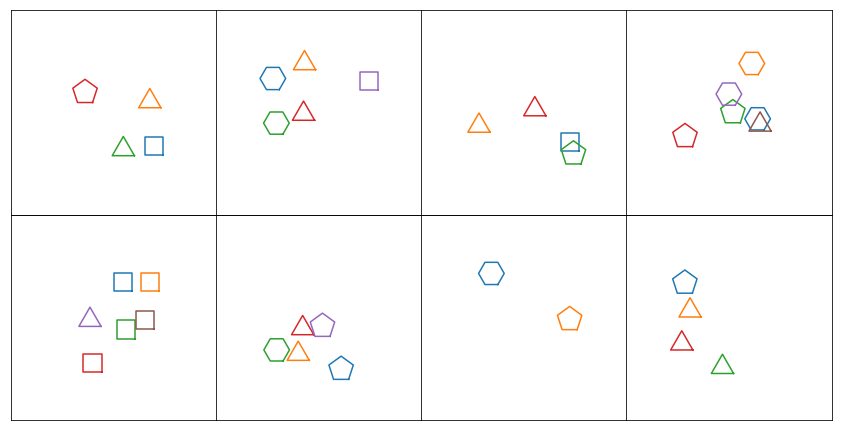

In [9]:
plots = [get_random_polygons_plot(i) for i in range(8)]
plot_grid(plots, [12, 6], [4, 2])

# Plots - NSR

In [13]:
class Plotter():

    def __init__(self, A):
        self._initialize(A)
        
    def _initialize(self, A):
        self.A = A
        self.normalize()
        
    def add_plot(self, A):
        
        for A_ in A:
            self.A.append(A_)
        self.normalize()
        
        return self
            
    def normalize(self):
        
        A = self.A
        
        a = np.concatenate(A).T.ravel()
        x, y = a[:len(a)//2], a[len(a)//2:]
        xc, yc = max(x)-min(x), max(y)-min(y)
        c = max(xc, yc)
        self.c = c
        
        self.A = [(A_-[min(x)+xc/2, min(y)+yc/2])/c
                  for A_ in A]
        
        return self

    def rotate(self, ro):
        
        sin, cos = np.sin, np.cos
        angle = np.pi/180*ro
        
        ro_mat = np.array(
            [cos(angle), -sin(angle), sin(angle), cos(angle)]
        ).reshape(2, 2)
        
        self.A = [A_.dot(ro_mat) for A_ in self.A]
        
        return self
        
    def move(self, direction):
        self.A = [A_+direction for A_ in self.A]
        return self
        
    def resize(self, size):
        self.A = [A_*size for A_ in self.A]
        return self
        
    def shake(self, resol=60, window=10, ratio=0.006):

        def _get_line(p1, p2):
            direction = p2-p1
            resol_ = int(resol*np.linalg.norm(direction))
            line = np.linspace(0, 1, resol_)
            return [p1+direction*v for v in line][:-1]

        def shake_A(A_):
            lines = [
                _get_line(A_[i], A_[i+1])
                for i in range(len(A_)-1)
            ]
            line = np.concatenate(lines)
            noise = np.random.randn(*line.shape)
            ma_noise = pd.Series(noise.ravel()).rolling(window).mean()
            noise = np.array(ma_noise.fillna(0)).reshape(noise.shape)
            return np.concatenate([line+noise*ratio, A_[-1:]])
        
        A = self.A
        self.A = [shake_A(A_) for A_ in A if len(A_) > 1]
        return self

    def draw(self, margin=0.1):
        
        plt.figure(figsize=[3, 3])
        
        p = plt.axes([0, 0, 1, 1])
        for A_ in self.A:
            A_ = A_.T
            p.plot(A_[0], A_[1], c="black")
        p.get_xaxis().set_visible(False)
        p.get_yaxis().set_visible(False)
        axis = np.array([-0.5, 0.5, -0.5, 0.5])*(1+margin)
        p.axis(axis)
            
        plt.show()

In [31]:
def plot_grid(plots, figsize, col8row, margin=0.05):

    col_n, row_n = col8row
    plot_n = len(plots)
    w = (1 - margin) / col_n
    h = (1 - margin) / row_n
    l = b = margin

    plt.figure(figsize=figsize)
    
    graphs = [plt.axes([l+w*(i%col_n), 
              b+h*(i//col_n), 
              w, h])
              for i in range(plot_n)]

    for i in range(plot_n):
        graph, plot = graphs[i], plots[i]
        if type(plot) != list:
            graph.imshow(plot)
        else:
            for plot_ in plot:
                plot_ = plot_.T
                graph.plot(plot_[0], plot_[1], c="black")
            graph.axis([-0.55, 0.55, -0.55, 0.55])
        graph.get_xaxis().set_visible(False)
        graph.get_yaxis().set_visible(False)
        
    plt.show()

In [22]:
plots = []

A_ = np.array([[1, 2], [2, 1], [1, 3], [1, 1]])
A = [A_, A_-[-0.1, 1], A_/2]
p = Plotter(A).shake()
plots.append(p.A)

A = []
A.append(np.array([[0, 4], [2, 5], [2, 3], [1, 1], [1.2, 3], [0, 4]]))
A.append(np.array([[0, 2], [4, 2]]))
p = Plotter(A).shake().rotate(60).normalize()
plots.append(p.A)

A_ = get_polygon(4)
A = [A_, A_/3]
p = Plotter(A).resize(0.5).shake()
plots.append(p.A)

A1 = Plotter([get_polygon(3), get_polygon(5)]).move([0.5, 0.3]).resize(0.4).A
A2 = Plotter([get_polygon(3)]).move([-1.5, -1.5]).resize(0.2).A
p = Plotter(A1+A2).shake().resize(0.8)
plots.append(p.A)

A_ = get_polygon(13)
A = [A_+1, A_+3, A_*0.3+4]
p = Plotter(A).shake()
plots.append(p.A)

A = [A_ for A_ in get_random_polygons_plot(23)]
p = Plotter(A)
plots.append(p.A)

A1 = np.array([[1, 0], [0, 0]])
A2 = np.array([[0, 1], [0, 0]])
A = [A1, A2*2-[0, 1], A1+1, A2-1]
p = Plotter(A).add_plot([get_polygon(80)]).rotate(30).normalize().shake().resize(0.8)
plots.append(p.A)

A_ = np.array([
    [1, 1], [-1, 1], [-1, -1], [1, -1],
    [1, 0.6], [-0.6, 0.6], [-0.6, -0.6], [0.6, -0.6],
    [0.6, 0.3], [-0.3, 0.3]
])
A = [A_]
p = Plotter(A).rotate(10).shake(ratio=0.01).resize(0.6)
plots.append(p.A)

A_ = get_polygon(6)
A_line = np.array([[1, 0], [-1, 0]])
A1 = Plotter([A_]).A
A2 = Plotter([A_line]).A
A3 = Plotter([A_line]).rotate(60).A
A4 = Plotter([A_line]).rotate(120).A
p = Plotter(A1+A2+A3+A4)
plots.append(p.A)

A1 = np.array([[0, 0], [1, 0], [1, 1], [0, 1], [0, 0]])
A2 = np.array([[1, 1], [1.3, 1.3], [0.3, 1.3], [0, 1]])
A3 = np.array([[1.3, 1.3], [1.3, 0.3], [1, 0]])
A4 = np.array([[0.3, 1.3], [0.3, 0.3], [0, 0]])
A5 = np.array([[0.3, 0.3], [1.3, 0.3]])
A = [A1, A2, A3, A4, A5]
p = Plotter(A).resize(0.5).shake()
plots.append(p.A)

imgs = []
for i in range(9, -1, -1):
    img = plt.imread("./pgimg/0%d.png"%i)
    mini = min(img.shape[:2])
    imgs.append(img[:mini, :mini, :])
    
plots += imgs


idxs = np.random.choice(range(len(plots)), len(plots), replace=False)
plot_grid([plots[i] for i in idxs], [12, 15], [4, 5])

FileNotFoundError: [Errno 2] No such file or directory: './pgimg/09.png'